In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import utils
import cv2
import numpy as np
import imageio
import os
import kornia

In [2]:
# gram_matrix = utils.gram_matrix
# Normalization = utils.Normalization

# #--------------------------------------------- compute style loss and content loss (l1 loss)-----------------------------------------------
# class CL(nn.Module):
#     def __init__(self, target):
#         super(CL, self).__init__()
#         self.target = target.detach()

#     def forward(self, input):
#         self.loss = F.l1_loss(input, self.target)
#         return input

# class SL(nn.Module):
#     def __init__(self, target):
#         super(SL, self).__init__()
#         self.target = gram_matrix(target).detach()

#     def forward(self, input):
#         G = gram_matrix(input)
#         self.loss = F.l1_loss(G, self.target)
#         return input



In [102]:
gram_matrix = utils.gram_matrix
Normalization = utils.Normalization

#--------------------------------------------- compute style loss and content loss (mse loss)-----------------------------------------------
class CL(nn.Module):
class CL(nn.Module):
    def __init__(self, target):
        super(CL, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class SL(nn.Module):
    def __init__(self, target):
        super(SL, self).__init__()
        self.target = gram_matrix(target).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [103]:
#-----------------------------------------------------------baseline Model--------------------------------------------------------------------
def nst_model(content_img, style_img):
    vgg = models.vgg19(pretrained=True).features.eval()
        
    normalization = Normalization(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    content_img = content_img.detach()
    style_img = style_img.detach()
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0
    for name, layer in vgg._modules.items():
        
        if name in ['0','2','5','7','10','12','14','16','19','21','23','25','28','30','32','34']:
            model.add_module('conv_{}'.format(i),layer)
            i += 1

        elif name in ['3','8','13','15','17','24','26','31','33','35']:
            layer = nn.ReLU(inplace=False)
            model.add_module('relu_{}'.format(i),layer)
            i += 1

        elif name in ['4','9','18','27','36']:
            model.add_module('maxpool_{}'.format(i),layer)
            i += 1

        elif name in ['1','6','11','20','29']:
            layer = nn.ReLU(inplace=False)
            model.add_module('relu_{}'.format(i),layer)
            style_target = model(style_img)
            style_loss = SL(style_target)
            style_losses.append(style_loss)
            model.add_module('styleloss_{}'.format(i),style_loss)
            i += 1
            
        elif name == '22':
            layer = nn.ReLU(inplace=False)
            model.add_module('relu_{}'.format(i),layer)
            content_target = model(content_img)
            content_loss = CL(content_target)
            content_losses.append(content_loss)
            model.add_module('contentloss_{}'.format(i),content_loss)
            i += 1 
            

    return model, style_losses, content_losses

In [66]:
# ## ----------------------------------------baseline model with average pooling---------------------------------
# def nst_model(content_img, style_img):
#     vgg = models.vgg19(pretrained=True).features.eval()
        
#     normalization = Normalization(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

#     content_img = content_img.detach()
#     style_img = style_img.detach()
#     content_losses = []
#     style_losses = []

#     model = nn.Sequential(normalization)
#     i = 0
#     for name, layer in vgg._modules.items():
        
#         if name in ['0','2','5','7','10','12','14','16','19','21','23','25','28','30','32','34']:
#             model.add_module('conv_{}'.format(i),layer)
#             i += 1

#         elif name in ['3','8','13','15','17','24','26','31','33','35']:
#             layer = nn.ReLU(inplace=False)
#             model.add_module('relu_{}'.format(i),layer)
#             i += 1

#         elif name in ['4','9','18','27','36']:
#             layer = nn.AvgPool2d(kernel_size=2, stride=2)
#             model.add_module('avgpool_{}'.format(i),layer)
#             i += 1

#         elif name in ['1','6','11','20','29']:
#             layer = nn.ReLU(inplace=False)
#             model.add_module('relu_{}'.format(i),layer)
#             style_target = model(style_img)
#             style_loss = SL(style_target)
#             style_losses.append(style_loss)
#             model.add_module('styleloss_{}'.format(i),style_loss)
#             i += 1
            
#         elif name == '22':
#             layer = nn.ReLU(inplace=False)
#             model.add_module('relu_{}'.format(i),layer)
#             content_target = model(content_img)
#             content_loss = CL(content_target)
#             content_losses.append(content_loss)
#             model.add_module('contentloss_{}'.format(i),content_loss)
#             i += 1 
            

#     return model, style_losses, content_losses

In [19]:
#-----------------------------------------------baseline model + some improved tricks------------------------------------------
# def nst_model(content_img, style_img):
#     vgg = models.vgg19(pretrained=True).features.eval()
        
#     normalization = Normalization(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

#     content_img = content_img.detach()
#     style_img = style_img.detach()
#     content_losses = []
#     style_losses = []

#     model = nn.Sequential(normalization)

#     i = 0
#     for name, layer in vgg._modules.items():
        
#         if name in ['0','2','5','7','10','12','14','16','19','21','23','25','28','30','32','34']:
#             model.add_module('conv_{}'.format(i),layer)
#             i += 1

#         elif name in ['3','8','22','15','17','24','26','31','33','35']:
#             layer = nn.ReLU(inplace=False)
#             model.add_module('relu_{}'.format(i),layer)
#             i += 1

#         elif name in ['4','9','18','27','36']:
#             layer = nn.AvgPool2d(kernel_size=2, stride=2)
#             model.add_module('avgpool_{}'.format(i),layer)
#             i += 1

#         elif name in ['1','6','11','20','29']:
#             layer = nn.ReLU(inplace=False)
#             model.add_module('relu_{}'.format(i),layer)
#             style_target = model(style_img)
#             style_loss = SL(style_target)
#             style_losses.append(style_loss)
#             model.add_module('styleloss_{}'.format(i),style_loss)
#             i += 1
            
#         elif name == '13':
#             layer = nn.ReLU(inplace=False)
#             model.add_module('relu_{}'.format(i),layer)
#             content_target = model(content_img)
#             content_loss = CL(content_target)
#             content_losses.append(content_loss)
#             model.add_module('contentloss_{}'.format(i),content_loss)
#             i += 1 
            

#     return model, style_losses, content_losses

In [104]:
#-----------------------------------------------compute training time------------------------------------------------------------------
import datetime
def print_cost(start_time):
    '''
    compute time

    '''
    end_time = datetime.datetime.now()
    print('total time：' + str(end_time - start_time).split('.')[0] + '.')

In [105]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import model
import utils

nst = nst_model
loader = utils.loader
imshow = utils.imshow


def main(content_img,style_img,size,steps,c_weight,s_weight):


    content_img, style_img = loader(content_img, style_img, size = size)
    n, c, h, w = content_img.data.size()
    
    input_img = content_img.clone() # set initial input as content image
    input_img = torch.randn(content_img.data.size()) # set initial input as random noise


    model, style_losses, content_losses  = nst(content_img, style_img)
    
### add data augmentation
#     transform = nn.Sequential(kornia.augmentation.RandomResizedCrop(size=(w, h), scale=(.97, 1.), ratio=(.97, 1.03)),kornia.augmentation.RandomRotation(degrees=1.))
### change optimizer
#     optimizer = optim.Adam([input_img.requires_grad_()],lr=0.05)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    step = [0]
    while step[0] <= steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
#             output = model(transform(input_img))
            output = model(input_img)
            cl = 0
            sl = 0
            i = 0
            for c_loss in content_losses:
                cl += c_loss.loss * c_weight[0]
            for s_loss in style_losses:
                sl += s_loss.loss * s_weight[i]
                i += 1

            loss = cl + sl
            loss.backward()

            if step[0] % 50 == 0:
                print('Step : {}'. format(step))
                print('Style Loss : {:3f} Content Loss: {:3f}'.format(
                    sl.item(), cl.item()))

            step[0] += 1

            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0,1)
    return input_img

    imshow(content_img, title = 'Input image')
    plt.show()

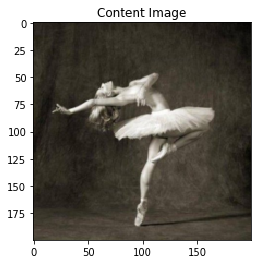

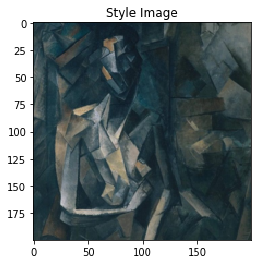

Step : [0]
Style Loss : 4.671554 Content Loss: 0.000000
Step : [50]
Style Loss : 1.110919 Content Loss: 0.618748
Step : [100]
Style Loss : 0.842633 Content Loss: 0.576873
Step : [150]
Style Loss : 0.734085 Content Loss: 0.557353
Step : [200]
Style Loss : 0.693993 Content Loss: 0.542855
Step : [250]
Style Loss : 0.677996 Content Loss: 0.535566
Step : [300]
Style Loss : 0.669527 Content Loss: 0.530739
Step : [350]
Style Loss : 0.663334 Content Loss: 0.528063
Step : [400]
Style Loss : 0.660031 Content Loss: 0.524761
Step : [450]
Style Loss : 0.656497 Content Loss: 0.522827
Step : [500]
Style Loss : 0.653591 Content Loss: 0.520945
Step : [550]
Style Loss : 0.651445 Content Loss: 0.519293
Step : [600]
Style Loss : 0.649221 Content Loss: 0.518175
Step : [650]
Style Loss : 0.647873 Content Loss: 0.516785
Step : [700]
Style Loss : 0.646254 Content Loss: 0.516038
Step : [750]
Style Loss : 0.645020 Content Loss: 0.515301
Step : [800]
Style Loss : 0.644352 Content Loss: 0.514246
Step : [850]
Styl

<Figure size 432x288 with 0 Axes>

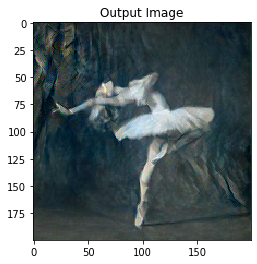

In [95]:
#----------------------------------------baseline experiment (content image as initial input)----------------------------------------------
if __name__ == "__main__":
    content_weights = [1e0]
#     style_weight = [1e8/n for n in [64,128,256,512,512]]
#     style_weight = [100,1000,10000,100000,100000]
    style_weight=[100000]*5
    output = main(content_img='./images/dancing.jpg',style_img='images/picasso.jpg',size=200,steps=1000,c_weight=content_weights,s_weight=style_weight )

    plt.figure()
    imshow(output, title = 'Output Image',save_path='./images/out5')
    plt.pause(5)
    plt.show()

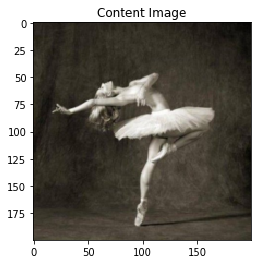

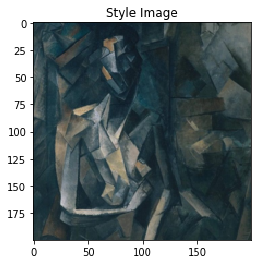

Step : [0]
Style Loss : 6031.437988 Content Loss: 18.903711
Step : [50]
Style Loss : 1.444965 Content Loss: 1.294962
Step : [100]
Style Loss : 0.987671 Content Loss: 0.952810
Step : [150]
Style Loss : 0.853248 Content Loss: 0.842715
Step : [200]
Style Loss : 0.793749 Content Loss: 0.786518
Step : [250]
Style Loss : 0.756192 Content Loss: 0.753536
Step : [300]
Style Loss : 0.731112 Content Loss: 0.729396
Step : [350]
Style Loss : 0.712905 Content Loss: 0.712053
Step : [400]
Style Loss : 0.697974 Content Loss: 0.699643
Step : [450]
Style Loss : 0.686743 Content Loss: 0.689953
Step : [500]
Style Loss : 0.677917 Content Loss: 0.682135
Step : [550]
Style Loss : 0.669157 Content Loss: 0.676205
Step : [600]
Style Loss : 0.662431 Content Loss: 0.669852
Step : [650]
Style Loss : 0.656978 Content Loss: 0.663960
Step : [700]
Style Loss : 0.651735 Content Loss: 0.659572
Step : [750]
Style Loss : 0.646540 Content Loss: 0.655825
Step : [800]
Style Loss : 0.642501 Content Loss: 0.651026
Step : [850]


<Figure size 432x288 with 0 Axes>

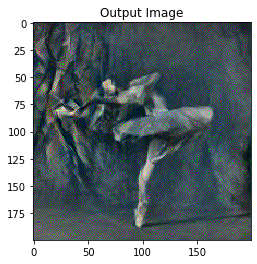

In [106]:
#-----------------------------------------------baseline experiment (random noise as initial input)-----------------------------------------------
if __name__ == "__main__":
    content_weights = [1e0]
#     style_weight = [1e8/n for n in [64,128,256,512,512]]
#     style_weight = [100,1000,10000,100000,100000]
    style_weight=[100000]*5
    output = main(content_img='./images/dancing.jpg',style_img='images/picasso.jpg',size=200,steps=1000,c_weight=content_weights,s_weight=style_weight )

    plt.figure()
    imshow(output, title = 'Output Image',save_path='./images/out5')
    plt.pause(5)
    plt.show()

In [20]:
#----------------------------------------------print the framework of pretrained model------------------------------------------------
vggnet = models.vgg19(pretrained=True).features.eval()
print(vggnet)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

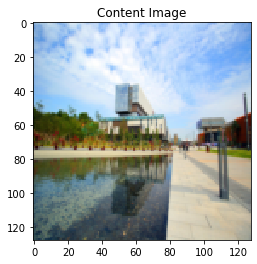

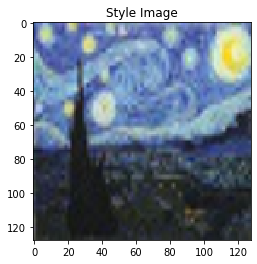

Step : [0]
Style Loss : 59.258350 Content Loss: 0.000000
Step : [50]
Style Loss : 4.748922 Content Loss: 3.281421
Step : [100]
Style Loss : 3.544271 Content Loss: 3.173323
Step : [150]
Style Loss : 3.124950 Content Loss: 3.135495
Step : [200]
Style Loss : 2.979539 Content Loss: 3.090052
Step : [250]
Style Loss : 2.898536 Content Loss: 3.059805
Step : [300]
Style Loss : 2.847117 Content Loss: 3.043701
Step : [350]
Style Loss : 2.818891 Content Loss: 3.028482
Step : [400]
Style Loss : 2.796867 Content Loss: 3.017800
Step : [450]
Style Loss : 2.778497 Content Loss: 3.011184
Step : [500]
Style Loss : 2.765597 Content Loss: 3.004362


<Figure size 432x288 with 0 Axes>

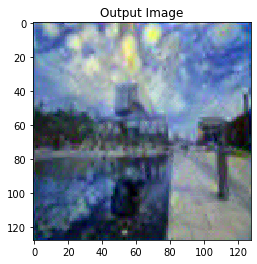

In [8]:
#-------------------------------compare the differentce of resolution---------------------------------

if __name__ == "__main__":
    content_weights = [1e0]
    style_weight = [1e8/n for n in [64,128,256,512,512]]
    output = main(content_img='./images/cuhksz.jpg',style_img='images/vangogh_69_50.jpg',size=128,steps=500,c_weight=content_weights,s_weight=style_weight )

    plt.figure()
    imshow(output, title = 'Output Image')
    plt.pause(5)
    plt.show()


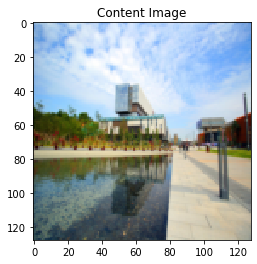

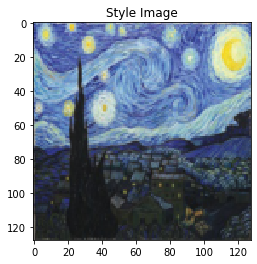

Step : [0]
Style Loss : 74.814606 Content Loss: 0.000000
Step : [50]
Style Loss : 7.342917 Content Loss: 5.603721
Step : [100]
Style Loss : 5.905530 Content Loss: 5.290074
Step : [150]
Style Loss : 5.348671 Content Loss: 5.183537
Step : [200]
Style Loss : 5.121134 Content Loss: 5.109847
Step : [250]
Style Loss : 5.004791 Content Loss: 5.060900
Step : [300]
Style Loss : 4.924708 Content Loss: 5.031344
Step : [350]
Style Loss : 4.870009 Content Loss: 5.010704
Step : [400]
Style Loss : 4.828712 Content Loss: 4.996052
Step : [450]
Style Loss : 4.796306 Content Loss: 4.985043
Step : [500]
Style Loss : 4.769428 Content Loss: 4.980337


<Figure size 432x288 with 0 Axes>

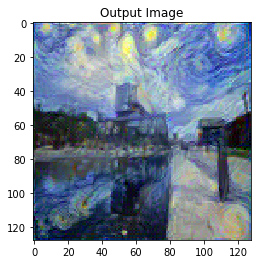

In [9]:

if __name__ == "__main__":
    content_weights = [1e0]
    style_weight = [1e8/n for n in [64,128,256,512,512]]
    output = main(content_img='./images/cuhksz.jpg',style_img='images/vangogh_138_100.jpg',size=128,steps=500,c_weight=content_weights,s_weight=style_weight )

    plt.figure()
    imshow(output, title = 'Output Image')
    plt.pause(5)
    plt.show()


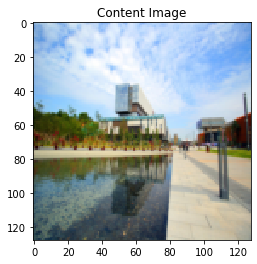

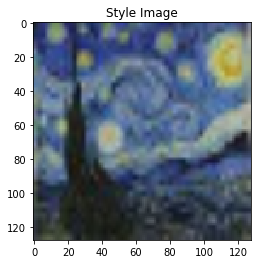

Step : [0]
Style Loss : 68.708649 Content Loss: 0.000000
Step : [50]
Style Loss : 5.092412 Content Loss: 3.374996
Step : [100]
Style Loss : 3.593845 Content Loss: 3.215581
Step : [150]
Style Loss : 2.974125 Content Loss: 3.135166
Step : [200]
Style Loss : 2.752556 Content Loss: 3.063559
Step : [250]
Style Loss : 2.640363 Content Loss: 3.015567
Step : [300]
Style Loss : 2.580554 Content Loss: 2.980398
Step : [350]
Style Loss : 2.547016 Content Loss: 2.957828
Step : [400]
Style Loss : 2.524350 Content Loss: 2.942533
Step : [450]
Style Loss : 2.500565 Content Loss: 2.935411
Step : [500]
Style Loss : 2.480608 Content Loss: 2.927934


<Figure size 432x288 with 0 Axes>

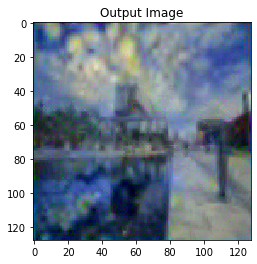

In [11]:
#----------------------------------difference of the resolution-----------------------------------
if __name__ == "__main__":
    content_weights = [1e0]
    style_weight = [1e8/n for n in [64,128,256,512,512]]
    output = main(content_img='./images/cuhksz.jpg',style_img='images/vangogh_starry_night_40.jpg',size=128,steps=500,c_weight=content_weights,s_weight=style_weight )

    plt.figure()
    imshow(output, title = 'Output Image')
    plt.pause(5)
    plt.show()

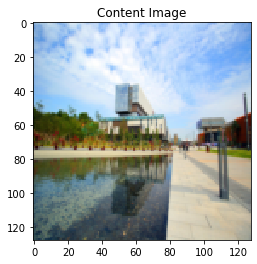

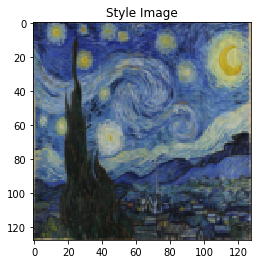

Step : [0]
Style Loss : 59.844837 Content Loss: 0.000000
Step : [50]
Style Loss : 7.339787 Content Loss: 4.974075
Step : [100]
Style Loss : 5.394610 Content Loss: 4.785542
Step : [150]
Style Loss : 4.753659 Content Loss: 4.625464
Step : [200]
Style Loss : 4.494278 Content Loss: 4.540284
Step : [250]
Style Loss : 4.348546 Content Loss: 4.491289
Step : [300]
Style Loss : 4.268470 Content Loss: 4.449748
Step : [350]
Style Loss : 4.217138 Content Loss: 4.427691
Step : [400]
Style Loss : 4.190047 Content Loss: 4.405459
Step : [450]
Style Loss : 4.160895 Content Loss: 4.397544
Step : [500]
Style Loss : 4.139826 Content Loss: 4.389591


<Figure size 432x288 with 0 Axes>

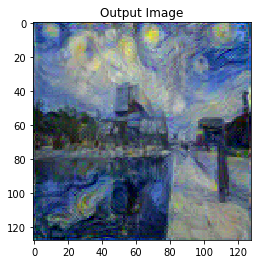

In [12]:
if __name__ == "__main__":
    content_weights = [1e0]
    style_weight = [1e8/n for n in [64,128,256,512,512]]
    output = main(content_img='./images/cuhksz.jpg',style_img='images/vangogh_starry_night_300.jpg',size=128,steps=500,c_weight=content_weights,s_weight=style_weight )

    plt.figure()
    imshow(output, title = 'Output Image')
    plt.pause(5)
    plt.show()

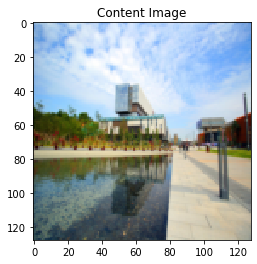

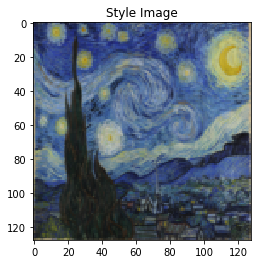

Step : [0]
Style Loss : 56.405895 Content Loss: 0.000000
Step : [50]
Style Loss : 7.245872 Content Loss: 4.907330
Step : [100]
Style Loss : 5.332838 Content Loss: 4.730207
Step : [150]
Style Loss : 4.672286 Content Loss: 4.609270
Step : [200]
Style Loss : 4.399894 Content Loss: 4.540054
Step : [250]
Style Loss : 4.272526 Content Loss: 4.476940
Step : [300]
Style Loss : 4.194181 Content Loss: 4.446716
Step : [350]
Style Loss : 4.139206 Content Loss: 4.431231
Step : [400]
Style Loss : 4.101515 Content Loss: 4.420061
Step : [450]
Style Loss : 4.070986 Content Loss: 4.413405
Step : [500]
Style Loss : 4.049727 Content Loss: 4.404920


<Figure size 432x288 with 0 Axes>

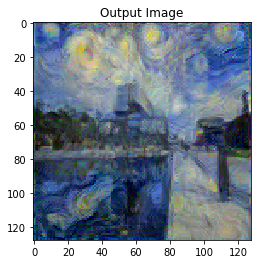

In [13]:
if __name__ == "__main__":
    content_weights = [1e0]
    style_weight = [1e8/n for n in [64,128,256,512,512]]
    output = main(content_img='./images/cuhksz.jpg',style_img='images/vangogh_starry_night.jpg',size=128,steps=500,c_weight=content_weights,s_weight=style_weight )

    plt.figure()
    imshow(output, title = 'Output Image')
    plt.pause(5)
    plt.show()

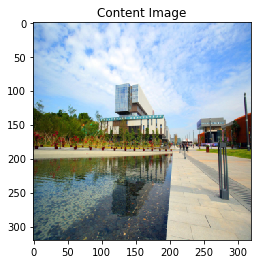

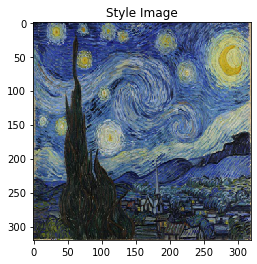

Step : [0]
Style Loss : 59.179031 Content Loss: 0.000000
Step : [50]
Style Loss : 2.708701 Content Loss: 1.750303
Step : [100]
Style Loss : 1.701046 Content Loss: 1.511562
Step : [150]
Style Loss : 1.467425 Content Loss: 1.416008
Step : [200]
Style Loss : 1.349473 Content Loss: 1.370802
Step : [250]
Style Loss : 1.287802 Content Loss: 1.338383
Step : [300]
Style Loss : 1.254921 Content Loss: 1.317599
Step : [350]
Style Loss : 1.232112 Content Loss: 1.304784
Step : [400]
Style Loss : 1.219488 Content Loss: 1.294616
Step : [450]
Style Loss : 1.211213 Content Loss: 1.286215
Step : [500]
Style Loss : 1.204080 Content Loss: 1.280592


<Figure size 432x288 with 0 Axes>

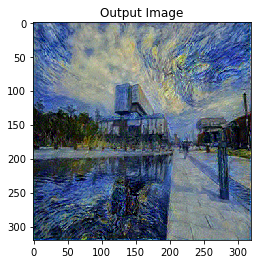

In [20]:
if __name__ == "__main__":
    content_weights = [1e0]
    style_weight = [1e8/n for n in [64,128,256,512,512]]
    output = main(content_img='./images/cuhksz.jpg',style_img='images/vangogh_starry_night_300.jpg',size=320,steps=500,c_weight=content_weights,s_weight=style_weight )

    plt.figure()
    imshow(output, title = 'Output Image')
    plt.pause(5)
    plt.show()

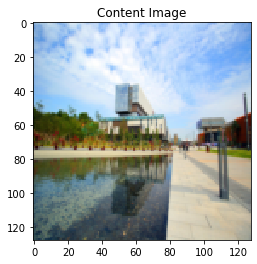

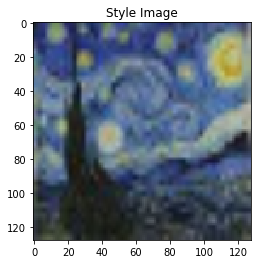

Step : [0]
Style Loss : 8.136694 Content Loss: 0.000000
Step : [50]
Style Loss : 0.160378 Content Loss: 0.125636
Step : [100]
Style Loss : 0.080533 Content Loss: 0.088195
Step : [150]
Style Loss : 0.071803 Content Loss: 0.075623
Step : [200]
Style Loss : 0.069982 Content Loss: 0.071833
Step : [250]
Style Loss : 0.069285 Content Loss: 0.070194
Step : [300]
Style Loss : 0.068949 Content Loss: 0.069245
Step : [350]
Style Loss : 0.068711 Content Loss: 0.068672
Step : [400]
Style Loss : 0.068531 Content Loss: 0.068257
Step : [450]
Style Loss : 0.068391 Content Loss: 0.067909
Step : [500]
Style Loss : 0.068288 Content Loss: 0.067634
total time：0:06:48.


<Figure size 432x288 with 0 Axes>

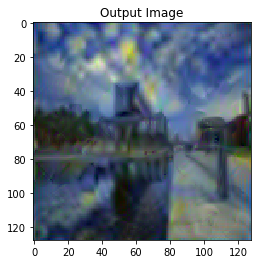

In [17]:
#----------------------------------------------average pooling---------------------------------------------
if __name__ == "__main__":

    content_weights = [1e0]
    style_weight = [1e8/n for n in [64,128,256,512,512]]
    start_time = datetime.datetime.now()
    output = main(content_img='./images/cuhksz.jpg',style_img='images/vangogh_starry_night_40.jpg',size=128,steps=500,c_weight=content_weights,s_weight=style_weight )
    print_cost(start_time)
    plt.figure()
    imshow(output, title = 'Output Image')
    plt.pause(5)
    plt.show()

<PIL.Image.Image image mode=RGB size=128x128 at 0x1B12C34B8C8>


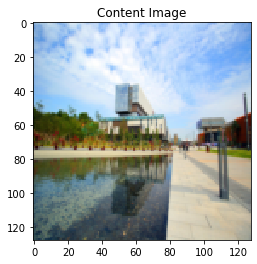

<PIL.Image.Image image mode=RGB size=128x128 at 0x1B12C07CD48>


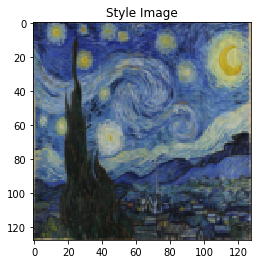

Step : [0]
Style Loss : 6.457451 Content Loss: 0.000000
Step : [50]
Style Loss : 0.133398 Content Loss: 0.067443
Step : [100]
Style Loss : 0.096379 Content Loss: 0.045946
Step : [150]
Style Loss : 0.089509 Content Loss: 0.040635
Step : [200]
Style Loss : 0.087317 Content Loss: 0.038287
Step : [250]
Style Loss : 0.086222 Content Loss: 0.037060
Step : [300]
Style Loss : 0.085538 Content Loss: 0.036337
Step : [350]
Style Loss : 0.085140 Content Loss: 0.035896
Step : [400]
Style Loss : 0.084866 Content Loss: 0.035578
Step : [450]
Style Loss : 0.084618 Content Loss: 0.035367
Step : [500]
Style Loss : 0.084486 Content Loss: 0.035149
<PIL.Image.Image image mode=RGB size=128x128 at 0x1B128166488>


<Figure size 432x288 with 0 Axes>

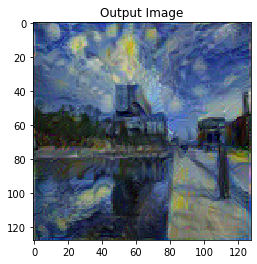

In [8]:
if __name__ == "__main__":
    content_weights = [1e0]
    style_weight = [1e3]
    output = main(content_img='./images/cuhksz.jpg',style_img='images/vangogh_starry_night_300.jpg',size=128,steps=500,c_weight=content_weights,s_weight=style_weight )

    plt.figure()
    imshow(output, title = 'Output Image')
    plt.pause(5)
    plt.show()

In [101]:
#--------------------------------------------------preserve content image color---------------------------------------------------------
# util function to preserve image color
from PIL import Image
import imageio
# util function to preserve image color
def original_color_transform(content, generated):
    generated = np.array(Image.fromarray(generated, mode='RGB').convert('YCbCr'))  # Convert to YCbCr color space
    generated[:, :, 1:] = content[:, :, 1:]
    generated = np.array(Image.fromarray(generated, mode='YCbCr').convert('RGB'))  # Convert to RGB color space
    return generated

content_image='./images/Sunlit Mountains.jpg'
generated_image='./images/Sunlit Mountains picasso_b.jpg'

image_suffix = "_original_color.jpg"
image_path = os.path.splitext(generated_image)[0] + image_suffix

generated_image = imageio.imread(generated_image, pilmode="RGB")
img_width, img_height, _ = generated_image.shape

content_image = imageio.imread(content_image, pilmode='YCbCr')
content_image = np.array(Image.fromarray(content_image).resize((img_height,img_width)))
img = original_color_transform(content_image, generated_image)
imageio.imwrite(image_path, img)

print("Image saved at path : %s" % image_path)


Image saved at path : ./images/Sunlit Mountains picasso_b_original_color.jpg


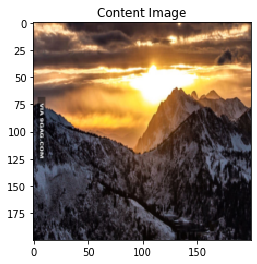

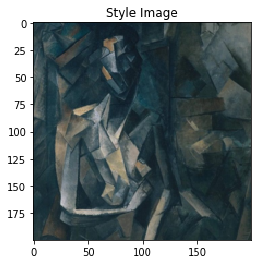

Step : [0]
Style Loss : 126.025665 Content Loss: 0.000000
Step : [50]
Style Loss : 4.841148 Content Loss: 4.366943
Step : [100]
Style Loss : 2.977696 Content Loss: 3.960884
Step : [150]
Style Loss : 2.564672 Content Loss: 3.799668
Step : [200]
Style Loss : 2.366311 Content Loss: 3.727349
Step : [250]
Style Loss : 2.273020 Content Loss: 3.679953
Step : [300]
Style Loss : 2.228358 Content Loss: 3.647133
Step : [350]
Style Loss : 2.199516 Content Loss: 3.627128
Step : [400]
Style Loss : 2.180286 Content Loss: 3.611709
Step : [450]
Style Loss : 2.166554 Content Loss: 3.600414
Step : [500]
Style Loss : 2.155823 Content Loss: 3.592618


<Figure size 432x288 with 0 Axes>

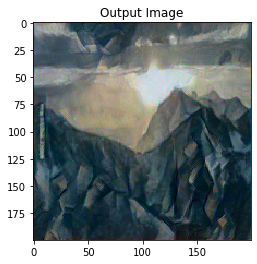

In [97]:
if __name__ == "__main__":
    content_weights = [1e0]
    style_weight = [1000000]*5
    output = main(content_img='./images/Sunlit Mountains.jpg',style_img='images/picasso.jpg',size=200,steps=500,c_weight=content_weights,s_weight=style_weight )

    plt.figure()
    imshow(output, title = 'Output Image',save_path='./images/Sunlit Mountains picasso_b')
    plt.pause(5)
    plt.show()


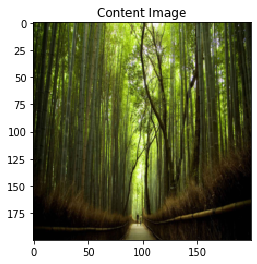

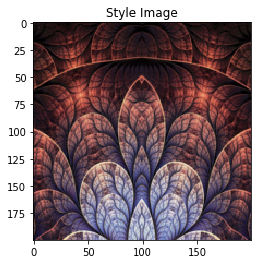

Step : [0]
Style Loss : 679.038147 Content Loss: 0.000000
Step : [50]
Style Loss : 12.809193 Content Loss: 13.124469
Step : [100]
Style Loss : 7.501628 Content Loss: 11.956345
Step : [150]
Style Loss : 6.211887 Content Loss: 11.537638
Step : [200]
Style Loss : 5.666083 Content Loss: 11.300842
Step : [250]
Style Loss : 5.389136 Content Loss: 11.138163
Step : [300]
Style Loss : 5.208880 Content Loss: 11.035114
Step : [350]
Style Loss : 5.092980 Content Loss: 10.951361
Step : [400]
Style Loss : 4.995504 Content Loss: 10.898602
Step : [450]
Style Loss : 4.927703 Content Loss: 10.856040
Step : [500]
Style Loss : 4.879161 Content Loss: 10.822423


<Figure size 432x288 with 0 Axes>

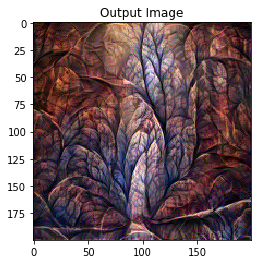

In [99]:
if __name__ == "__main__":
    content_weights = [1e0]
    style_weight = [1000000]*5
    output = main(content_img='./images/sagano_bamboo_forest.jpg',style_img='images/patterned_leaves.jpg',size=200,steps=500,c_weight=content_weights,s_weight=style_weight )

    plt.figure()
    imshow(output, title = 'Output Image',save_path='./images/bamboo leave_b')
    plt.pause(5)
    plt.show()
